### Set-up

In [16]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
import spacy
import spacy.displacy as displacy
import pyLDAvis
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim_models as gensimvis

In [17]:
# Get the current working directory
work_dir = os.getcwd()
file_name = "spam_dataset.csv"

# Join the directory and filename
file_path = os.path.join(work_dir, file_name)

# Check if the file exists
if os.path.exists(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)
    display(df.tail())
else:
    print(f"The file at {file_path} does not exist.")


,Unnamed: 0,label,text,label_num
5166,1518,ham,Subject: put the 10 on the ft\nthe transport v...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\nhpl ...,0
5168,2933,ham,Subject: calpine daily gas nomination\n>\n>\nj...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0
5170,4807,spam,Subject: important online banking alert\ndear ...,1


In [18]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stede\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stede\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# Load spaCy's English NLP model
nlp = spacy.load("en_core_web_sm")

# analyze the last email of the dataset with spaCy
email_to_analyze = df.iloc[-1, 2]
doc = nlp(email_to_analyze)
"""
The 'doc' variable here only stores the representation of the last email's linguistic features and entities, 
using spaCy functionalities. This code snippet has the only purpose of showing how the method works.
I'll use the 'doc' variable again, in section called 'Named Entity Recognition', but this time it will store
all Organizations' names from non-spam emails.
"""

# Use IPython display function for entity recognition
display(HTML(displacy.render(doc, style='ent', page=True)))


c:\Users\stede\anaconda3\envs\NLP\lib\site-packages\spacy\displacy\__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<IPython.core.display.HTML object>

### Preprocessing

In [20]:
""" 
Both tokenization and stop words removal could be performed using SpaCy. Nevertheless, NLTK 
offers a convenient set of stop words. This combination allows leveraging the strengths of 
both libraries, considering that NLTK has a larger set of stop words.
Similarly, for lemmatization, SpaCy provides a lemmatizer, but NLTK's WordNet Lemmatizer is 
a more accurate and widely used lemmatization tool.
So here SpaCy will be used for tokenization, while NLTK will be used for stop words removal
and lemmatization.
"""
# Text preprocessing function
def text_preprocess(text):
    # Lowercasing - converts text to lowercase to ensure consistency
    text = text.lower()
    # Punctuation removal
    text = text.translate(str.maketrans('', '', string.punctuation))
    """ 
    'str.maketrans()' method creates a translation table. In this table, the first two 
    arguments are empty strings, indicating that each character in the 'string.punctuation' 
    list will be mapped to nothing (i.e., removed). 
    'string.punctuation' contains all ASCII punctuation characters (',', '?', '.', etc.).
    """
    # Remove remaining non-alphabetic characters
    text = ''.join(char for char in text if char.isalpha() or char.isspace())
    # Remove multiple spaces
    text = ' '.join(text.split())
    """   
    The '.join()' method indirectly eliminates non-alphabetic characters by joining only the 
    alphabetical characters and spaces from the input text. This is achieved by removing 
    non-alphabetic characters (except for spaces) and concatenating the remaining characters 
    into a single string using an empty string ('') as the separator. 

    However, when printing the resulting documents, I found out there were many multiple 
    spaces counted as characters; this messed up the results, especially when the program
    was asked to divide the documents according to their topic. For that reason, the 
    following line uses '.join()' and 'split()' to ensure there is only a single space 
    between words, eliminating any extra spaces that might cause issues in downstream 
    processing or analysis.
    """
    
    # Tokenization using spaCy - tokenizes the text into a list of tokens (words)
    tokens = [token.text for token in nlp(text)]
    # Exclude the word 'subject' from the tokens, as it is present in every email basically
    tokens = [token for token in tokens if token.lower() != 'subject']
    
    # Stop words removal - removes common stop words using NLTK's set of English stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization using NLTK (Natural Language ToolKit) WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # The function returns the preprocessed text, i.e., the result of joining the processed tokens into a single string.
    return ' '.join(tokens)

# Apply text preprocessing to the entire dataset (more precisely, to the 'text' column of 'df')
df['preprocessed_text'] = df['text'].apply(text_preprocess)

In [21]:
# Check the results of the preprocessing
print(df['preprocessed_text'][:])


0       enron methanol meter follow note gave monday p...
1       hpl nom january see attached file hplnol xl hp...
2       neon retreat ho ho ho around wonderful time ye...
3       photoshop window office cheap main trending ab...
4       indian spring deal book teco pvr revenue under...
                              ...                        
5166    put ft transport volume decreased contract tha...
5167    following noms hpl take extra mmcf weekend try...
5168    calpine daily gas nomination julie mention ear...
5169    industrial worksheet august activity attached ...
5170    important online banking alert dear valued cit...
Name: preprocessed_text, Length: 5171, dtype: object


In [22]:
""" # In this cell, there is an attempt to use stemming instead of lemmatization.
# The results are shown at the end of the section "Training and evaluation".

# Text preprocessing function with stemming
def text_preprocess_stemming(text):
    # Lowercasing - converts text to lowercase to ensure consistency
    text = text.lower()
    # Punctuation removal
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove remaining non-alphabetic characters
    text = ''.join(char for char in text if char.isalpha() or char.isspace())
    # Remove multiple spaces
    text = ' '.join(text.split())
    # Tokenization using spaCy - tokenizes the text into a list of tokens (words)
    tokens = [token.text for token in nlp(text)]
    # Stop words removal - removes common stop words using NLTK's set of English stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Stemming using NLTK Porter Stemmer
    porter_stemmer = PorterStemmer()
    tokens = [porter_stemmer.stem(token) for token in tokens]
    
    # The function returns the preprocessed text, i.e., the result of joining the processed tokens into a single string.
    return ' '.join(tokens)

# Apply text preprocessing with stemming to the entire dataset
df['preprocessed_text'] = df['text'].apply(text_preprocess_stemming)

print(df['preprocessed_text'][:])
"""

' # In this cell, there is an attempt to use stemming instead of lemmatization.\n# The results are shown at the end of the section "Training and evaluation".\n\n# Text preprocessing function with stemming\ndef text_preprocess_stemming(text):\n    # Lowercasing - converts text to lowercase to ensure consistency\n    text = text.lower()\n    # Punctuation removal\n    text = text.translate(str.maketrans(\'\', \'\', string.punctuation))\n    # Remove remaining non-alphabetic characters\n    text = \'\'.join(char for char in text if char.isalpha() or char.isspace())\n    # Remove multiple spaces\n    text = \' \'.join(text.split())\n    # Tokenization using spaCy - tokenizes the text into a list of tokens (words)\n    tokens = [token.text for token in nlp(text)]\n    # Stop words removal - removes common stop words using NLTK\'s set of English stop words\n    stop_words = set(stopwords.words(\'english\'))\n    tokens = [token for token in tokens if token not in stop_words]\n    # Stemming 

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_text'], df['label_num'], test_size=0.2, random_state=42)

### Training and Evaluation

In this section, model_1 is trained on the whole dataset and evaluated on the entire test set, while model_2 uses cross-validation to train and evaluate the model on different data subsets. 
The results indicate that model_2 is a preferable choice, providing a more consistent estimate of the model's generalization performance.
That's why we will start from model_2, attempting to fine-tune the parameters in a way that minimizes the number of both false negatives and false positives (the latter also matters, as it's true we want to detect spam, but we don't want many potentially important emails to go into the spam folder).

In [24]:
""" # Build model_1 by training the entire dataset at once

model_1 = make_pipeline(CountVectorizer(), MultinomialNB())
model_1.fit(X_train, y_train)

# Add threshold of 0.35 to the predictions, to compare with model_2 based on the same parameters
threshold = 0.35
y_pred = (model_1.predict_proba(X_test)[:, 1] > threshold).astype(int)

# Evaluate the model with thresholding
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results for each fold
print(f"Threshold: {threshold}")
print(f"Accuracy: {accuracy:.3}")
print(f"Precision: {precision:.3}")
print(f"Recall: {recall:.3}")
print(f"F1 Score: {f1:.3}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate the confusion matrix model_1
conf_matrix_1 = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization
conf_matrix_df_1 = pd.DataFrame(conf_matrix_1, 
                                columns=['Predicted Negative', 'Predicted Positive'],
                                index=['Actual Negative', 'Actual Positive'])

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_df_1)
"""

' # Build model_1 by training the entire dataset at once\n\nmodel_1 = make_pipeline(CountVectorizer(), MultinomialNB())\nmodel_1.fit(X_train, y_train)\n\n# Add threshold of 0.35 to the predictions, to compare with model_2 based on the same parameters\nthreshold = 0.35\ny_pred = (model_1.predict_proba(X_test)[:, 1] > threshold).astype(int)\n\n# Evaluate the model with thresholding\naccuracy = accuracy_score(y_test, y_pred)\nprecision = precision_score(y_test, y_pred)\nrecall = recall_score(y_test, y_pred)\nf1 = f1_score(y_test, y_pred)\n\n# Print the results for each fold\nprint(f"Threshold: {threshold}")\nprint(f"Accuracy: {accuracy:.3}")\nprint(f"Precision: {precision:.3}")\nprint(f"Recall: {recall:.3}")\nprint(f"F1 Score: {f1:.3}")\nprint("Classification Report:\n", classification_report(y_test, y_pred))\n\n# Calculate the confusion matrix model_1\nconf_matrix_1 = confusion_matrix(y_test, y_pred)\n\n# Create a DataFrame for better visualization\nconf_matrix_df_1 = pd.DataFrame(conf_m

model_1 - Results:

    Threshold: 0.35
    Accuracy: 0.976
    Precision: 0.953
    Recall: 0.962
    F1 Score: 0.958
    
    Classification Report:
                precision    recall  f1-score   support

            0       0.99      0.98      0.98       742
            1       0.95      0.96      0.96       293

    accuracy                            0.98      1035
    macro avg       0.97      0.97      0.97      1035
    weighted avg    0.98      0.98      0.98      1035

    Confusion Matrix:
                     Predicted Negative  Predicted Positive
    Actual Negative                 728                  14
    Actual Positive                  11                 282

In [25]:
# Build model_2 by dividing the dataset in 5 folds and training them individually
num_splits = 5
stratified_kfold = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Create a function to evaluate model_2 on each fold
def evaluate_model_2(model_2, X_train, y_train, X_test, y_test, threshold):
    model_2.fit(X_train, y_train)
    
    # Adjust the decision threshold
    y_pred_proba = model_2.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)

    # Evaluate model_2
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print the results for each fold
    print(f"Threshold: {threshold}")
    print(f"Accuracy: {accuracy:.3}")
    print(f"Precision: {precision:.3}")
    print(f"Recall: {recall:.3}")
    print(f"F1 Score: {f1:.3}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Now you can use y_pred_fold to calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Create a DataFrame for better visualization
    conf_matrix_df_2 = pd.DataFrame(conf_matrix, 
                                columns=['Predicted Negative', 'Predicted Positive'],
                                index=['Actual Negative', 'Actual Positive'])

    # Display the confusion matrix
    print(f"Confusion Matrix:\n {conf_matrix_df_2}")
    
    # Return the predicted labels
    return y_pred

# Loop through the folds
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(df['preprocessed_text'], df['label_num'])):
    print(f"\nFold {fold + 1}:")

    # Split the data into training and testing sets for this fold
    X_train_fold, X_test_fold = df['preprocessed_text'].iloc[train_index], df['preprocessed_text'].iloc[test_index]
    y_train_fold, y_test_fold = df['label_num'].iloc[train_index], df['label_num'].iloc[test_index]

    # Your existing code for creating and training model_2
    model_2 = make_pipeline(CountVectorizer(), MultinomialNB())
    
    # Evaluate model_2 on this fold with specified threshold
    y_pred_fold = evaluate_model_2(model_2, X_train_fold, y_train_fold, X_test_fold, y_test_fold, threshold=0.1)



Fold 1:
Threshold: 0.1
Accuracy: 0.979
Precision: 0.954
Recall: 0.973
F1 Score: 0.964
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       735
           1       0.95      0.97      0.96       300

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.97      1035
weighted avg       0.98      0.98      0.98      1035

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                 721                  14
Actual Positive                   8                 292

Fold 2:
Threshold: 0.1
Accuracy: 0.985
Precision: 0.958
Recall: 0.99
F1 Score: 0.974
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       735
           1       0.96      0.99      0.97       299

    accuracy                           0.98      1034
   macro avg       0.98      0.99      0.98    

Fold 5 - Results:

    Threshold: 0.1
    Accuracy: 0.988
    Precision: 0.971
    Recall: 0.99
    F1 Score: 0.98
    
    Classification Report:

               precision    recall  f1-score   support
           0       1.00      0.99      0.99       734
           1       0.97      0.99      0.98       300

    accuracy                           0.99      1034
    macro avg      0.98      0.99      0.99      1034
    weighted avg   0.99      0.99      0.99      1034


    Confusion Matrix:
    
                     Predicted Negative  Predicted Positive
    Actual Negative                 725                   9
    Actual Positive                   3                 297


NOTE: I also tested model_2 performances introducing class weights (0.5 for class 0, 1 for class 1). However, due to marginal improvements, and considering increasing complexity and potential overfitting, I finally opted to retain the original class distribution for enhanced model interpretability and robustness.

The tables below compare the confusion matrices obtained with different thresholds. We can see that setting the threshold higher than the default 0.5 gives worse results, while lowering it to 0.3 basically returns the same outpus as the default threshold. A further decrease to 0.1 is slightly detrimental for the false positives (meaning that more non-spam emails will finish in the spam folder). Indeed, When the threshold is lowered from 0.5 to 0.1, the model becomes more sensitive, classifying more instances as positive (spam). This is evident from the increase in the number of predicted positives. However, the model makes a really good job in catching the actual positives, with only 3 false negatives (against 292 actual positives caught by the 0.5 threshold). For this reason, I'm keeping the threshold at 0.1, since it has show the best results overall (only 12 errors instead of 16 of the second-best threshold).

___________________________________________________________

Threshold: 0.7

                     Predicted Negative  Predicted Positive
    Actual Negative                 727                   7
    Actual Positive                  12                 288

___________________________________________________________

Threshold: 0.5
    
                     Predicted Negative  Predicted Positive
    Actual Negative                 726                   8
    Actual Positive                   8                 292

___________________________________________________________


Threshold: 0.3

                     Predicted Negative  Predicted Positive
    Actual Negative                 726                   8
    Actual Positive                   8                 292

___________________________________________________________


Threshold: 0.1

                     Predicted Negative  Predicted Positive
    Actual Negative                 725                   9
    Actual Positive                   3                 297

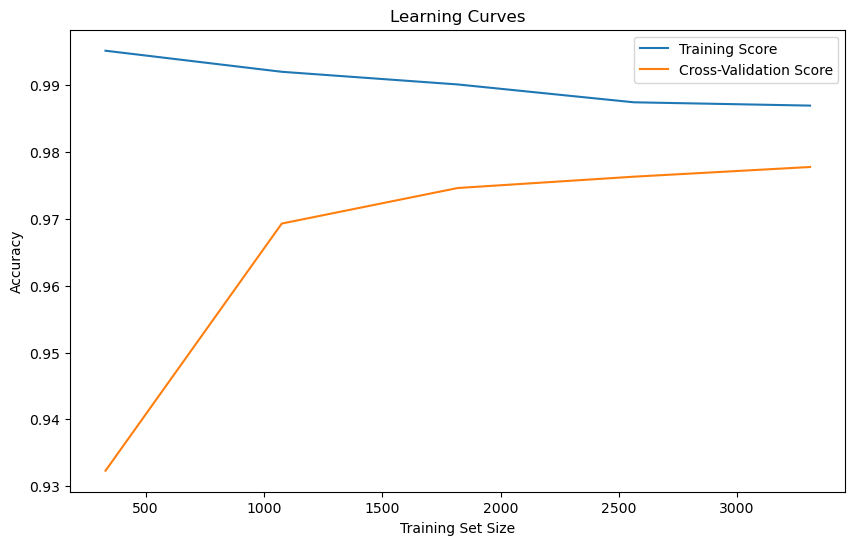

In [26]:
# Plot the learning curves for train and test sets
train_sizes, train_scores, test_scores = learning_curve(model_2, X_train, y_train, cv=5)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()


In [27]:
""" model_2 with lemmatization - results:
Below we can see the results obtained by applying stemming instead of lemmatization. For this experiment, I used 
stratified k-fold and a threshold of 0.35. 

The results are worse than those obtained with lemmatization:

    Fold 5:
    Threshold: 0.35
    Accuracy: 0.978
    Precision: 0.969
    Recall: 0.953
    F1 Score: 0.961

    Classification Report:
                precision    recall  f1-score   support

            0       0.98      0.99      0.98       734
            1       0.97      0.95      0.96       300

    accuracy                            0.98      1034
    macro avg       0.98      0.97      0.97      1034
    weighted avg    0.98      0.98      0.98      1034

    Confusion Matrix:
                     Predicted Negative  Predicted Positive
    Actual Negative                 725                   9
    Actual Positive                  14                 286
"""

' model_2 with lemmatization - results:\nBelow we can see the results obtained by applying stemming instead of lemmatization. For this experiment, I used \nstratified k-fold and a threshold of 0.35. \n\nThe results are worse than those obtained with lemmatization:\n\n    Fold 5:\n    Threshold: 0.35\n    Accuracy: 0.978\n    Precision: 0.969\n    Recall: 0.953\n    F1 Score: 0.961\n\n    Classification Report:\n                precision    recall  f1-score   support\n\n            0       0.98      0.99      0.98       734\n            1       0.97      0.95      0.96       300\n\n    accuracy                            0.98      1034\n    macro avg       0.98      0.97      0.97      1034\n    weighted avg    0.98      0.98      0.98      1034\n\n    Confusion Matrix:\n                     Predicted Negative  Predicted Positive\n    Actual Negative                 725                   9\n    Actual Positive                  14                 286\n'

### Topic Modeling

In [28]:
num_topics = 4

# Tokenization function using spaCy
def tokenize_text(text):
    return [token.text for token in nlp(text)]

# Tokenize and create corpus for Gensim
tokenized_text = df['preprocessed_text'].apply(tokenize_text)
dictionary = corpora.Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# TF-IDF Vectorization for spam emails
spam_emails = df[df['label_num'] == 1]['preprocessed_text']
vectorizer = TfidfVectorizer(tokenizer=tokenize_text)
spam_tfidf = vectorizer.fit_transform(spam_emails)

"""
I decided to use the Gensim LDA instead of the Scikit-learn LDA simply because 
the latter presented difficulties for me in finding a way to visualize 
the data in the same manner as the following cell demonstrates.
"""
# Train the Gensim LDA model
lda_gensim = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=15
)

# Display Gensim LDA Topics
topics_gensim = lda_gensim.print_topics(num_words=5)
print("\nGensim LDA Topics:")
for index, topic in enumerate(topics_gensim, start=1):
    print(f"Topic {index}: {topic}")

# Retrieve the numeric vectors representing the topics identified by the Gensim LDA model
gensim_topic_vectors = lda_gensim.get_topics()

# Calculate cosine similarity between topics
topic_distances_gensim = cosine_similarity(gensim_topic_vectors)

# Print the topic distances for Gensim
print("\nTopic Distances for Gensim:")
print(topic_distances_gensim.round(3))


c:\Users\stede\anaconda3\envs\NLP\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Gensim LDA Topics:
Topic 1: (0, '0.009*"http" + 0.006*"font" + 0.006*"td" + 0.005*"com" + 0.005*"height"')
Topic 2: (1, '0.062*"ect" + 0.033*"hou" + 0.023*"enron" + 0.016*"deal" + 0.013*"meter"')
Topic 3: (2, '0.018*"hpl" + 0.015*"enron" + 0.010*"gas" + 0.009*"mmbtu" + 0.009*"com"')
Topic 4: (3, '0.008*"com" + 0.007*"company" + 0.006*"please" + 0.005*"information" + 0.005*"new"')

Topic Distances for Gensim:
[[1.    0.077 0.203 0.345]
 [0.077 1.    0.26  0.213]
 [0.203 0.26  1.    0.341]
 [0.345 0.213 0.341 1.   ]]


It seems like the get_topics() method finds different kind of groups every time I run the code from scratch.
In any case, when setting num_topics = 5 or more, at least two topics where partially, if not almost totally overlapping.
Regarding the last iteration of the code, the topics are not always clear and, even if the pyLDAvis.display() method put big distances between the topics, sometimes the most recurring words are the same (e.g., "enron" or "com"). To conclude, the model says the topics are clearly defined, but further investigation might be needed to understand the content.

In [29]:
# Visualize topics
vis_data = gensimvis.prepare(lda_gensim, corpus, dictionary, sort_topics=False)
""" Gensimvis and pyLDAvis graphs show how well topics separate out.
If they are clear and distinct, that's good. If they overlap or are confusing, we might 
need to adjust the number of topics. In this case, 5 has proven to be the best choice, 
as increasing the number to 6 has led to an almost complete overlap between two topics.
"""
pyLDAvis.display(vis_data)

### Named Entity Recognition

In [30]:
# Separate non-spam emails
non_spam_emails = df[df['label_num'] == 0]['text']

# Extract organizations from non-spam emails
org_names = []
for email in non_spam_emails:
    doc = nlp(email)
    for ent in doc.ents:
        if ent.label_ in ['ORG']:
            org_names.append(ent.text)

# Print the extracted organization names
print("Extracted Organization Names:\n", org_names)

Extracted Organization Names:
 ['enron', 'brenham', 'foot locker canada', 'tenaska', 'tenaska', 'buckley 02 /', 'nathan l hlavaty / hou / ect @ ect', 'pat\nclynes / corp / enron @ enron', 'mike morris / corp /', 'tenaska', 'tenaska', 'tenaska', 'enron', 'pat clynes / corp /', 'parker / corp /', 'the houston exploration company', 'the enron corp\nsavings', 'the enron corp .', 'texas gas', 'north america corp .', '1 & 2', 'ami chokshi / corp /', 'ami chokshi / corp / enron @ enron\n', 'texas 77002', 'enron', 'mack / corp / enron @ enron', 'samson', 'lone star', ', inc', 'brenda', 'morgan', 'syscom - inc', 'michelle', 'diaz', 'stephanie', 'nyu', 'nyu', 'nyu', 'nyu', 'org', 'enron', 'enron', 'enron', 'enron', 'pg & e', 'pg & e texas', 'sherlyn will notify logistics', 'pg & e texas', 'pg & e', 'texas bulletin board', 'pg & e texas', 'pg & e texas', 'pg & e', 'pg & e', 'pg & e .', 'tenaska', 'lone star', 'el paso', 'chevron', 'hplc 04 / 01', 'chevron', 'hplc 04 / 01', 'chevron', 'hplc 04 / 0

In [31]:
# Get unique organization names
unique_org_names = set(org_names)

# Function to print a set in columns
def print_set_in_columns(set, num_columns=5):
    set_list = list(set)
    for i in range(0, len(set_list), num_columns):
        print(" | ".join(set_list[i:i + num_columns])) 

# Print the unique organization names in columns
print("Unique Sender Names:")
print_set_in_columns(unique_org_names)

Unique Sender Names:
lloyds | blue hill | midcon | north harris community college | cavanaug @ gustafson
cold & sinus effervescent
alka seltzer plus night | theresa | gas & oil southwest inc . | walter o & g / superior | texas edit logistics
resource type
kafus environmental industries , inc | steven p south / hou / ect @ ect | union carbide safety | daren - meter 1428 | duke
michelle | corp tax | mar , & apr | lauer | specialist
lynda munkres | commonwealth edison company | kilgore | smith @ enron | el
paso
elmendorf @ teradyne | the enron corp . | ena &
hplc | cp & l on | enron
corp .
chris riegler / corp / enron @ enron | mscott @ ngptrs | the sap financial systems | joann collins / corp / enron @ enron | phibro energy
inc .
lim | bmc | houston pipeline company anywhere | coastal oil & gas corporation | raleigh
finance & treasurer
 | & l | hplc 04 / 01 | first united methodist church | houston
richard
houston
georganne m . | pg & e to | laura harder / corp / enron | kerr - mcgee oil